# Embedding and Visualization for Variational Autoencoder
### A. Loading VAE pretrained model from previous notebook

In [9]:
import torch
import torchvision
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time, os
import argparse
from main_pvae import extract_data
ae_path = 'C:/PycharmProject/Amazon_Image_Similarity/Perceptual-Autoencoders-master/checkpoints/VAE_FourLayerCVAE_2021-01-22_03h44m09s.pt'
autoencoder = torch.load(ae_path, map_location='cpu')

args = argparse.ArgumentParser()
# Namespace(ae_batch_size=512, ae_epochs=50, ae_gammas=[0.0, 0.01], ae_networks=['FourLayerCVAE'], ae_repetitions=1,
#           ae_zs=[64, 128], autoencoder_index='autoencoder_index.csv', data='svhn', perceptual_layers=[5],
#           perceptual_nets=['None', 'alexnet'], predictor_batch_size=512, predictor_epochs=500,
#           predictor_repetitions=1, results_path='results.csv')
args.data = 'geo';                      args.data_path = 'C:/Project_Data/'
# AE
args.display_img_feat = 1  # false or epoch number to show >= num
args.ae_epochs = 20;                        args.ae_batch_size = 512;
args.ae_networks = ['FourLayerCVAE'];       args.ae_repetitions = 1;
args.ae_zs = [64, 128];                     args.ae_gammas = [0.01]
# Predictor
args.predictor_epochs = 2;              args.predictor_batch_size = 512;
args.predictor_repetitions = 1;
# Perceptual
args.perceptual_nets = ['None'];        args.perceptual_layers = [5];
# out_files
i = 0; fname = 'autoencoder_index_{:0>3d}.csv'
while os.path.exists(fname.format(i)): i += 1; args.autoencoder_index = fname.format(i)
i = 0; fname = 'results_{:0>3d}.csv'
while os.path.exists(fname.format(i)): i += 1; args.results_path = fname.format(i)


def encode_test(autoencoder, data_loader, batch_size=512, gpu=False):
    encoded_batches = []
    autoencoder.eval()
    if gpu:
        autoencoder.cuda()
    with torch.no_grad():
        for i, batch in enumerate(data_loader):

            if gpu:
                batch = batch.cuda()
            coded_batch = autoencoder.encode(batch)
            if gpu:
                coded_batch = (coded_batch[0].cpu(), coded_batch[1].cpu())
                # batch = batch.cpu()
            encoded_batches.append(coded_batch[0])
            print('\rBatch No: {:0>4d}'.format(i), end='')

    return torch.cat(encoded_batches, dim=0)

batch_size = 16
train_data, train_labels, valid_data, valid_labels, f_train, f_test = extract_data(args)
train_loader = DataLoader(train_data, batch_size, shuffle=False)
test_loader = DataLoader(valid_data, batch_size, shuffle=False)

timestamp = time.process_time()
print('Encode train data ...')
train_encoded = encode_test(autoencoder, train_loader, batch_size, gpu=True)
print('\nEncode test data ...')
test_encoded = encode_test(autoencoder, test_loader, batch_size, gpu=True)
autoencode_test_time = time.process_time() - timestamp


Encode train data ...
Batch No: 1687
Encode test data ...
Batch No: 0187

In [10]:
# shape of z (extracted feature) from a given image
test_encoded[0].shape

torch.Size([128])

## B. Retrieving 5 similar image using KNN

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



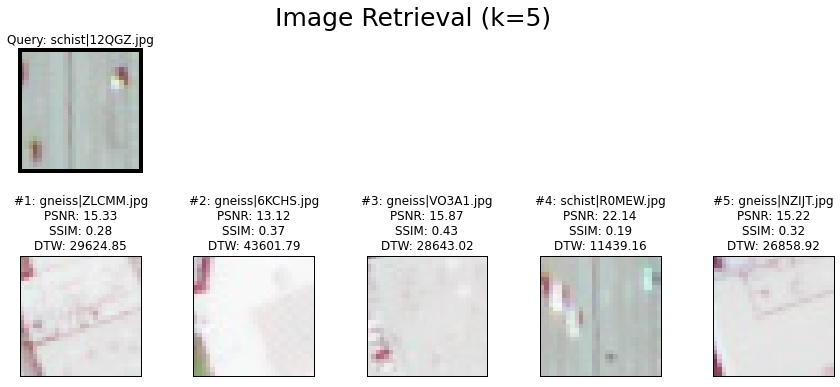

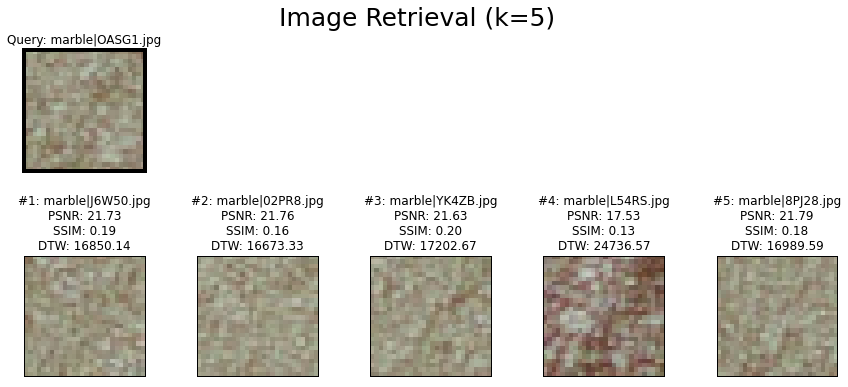

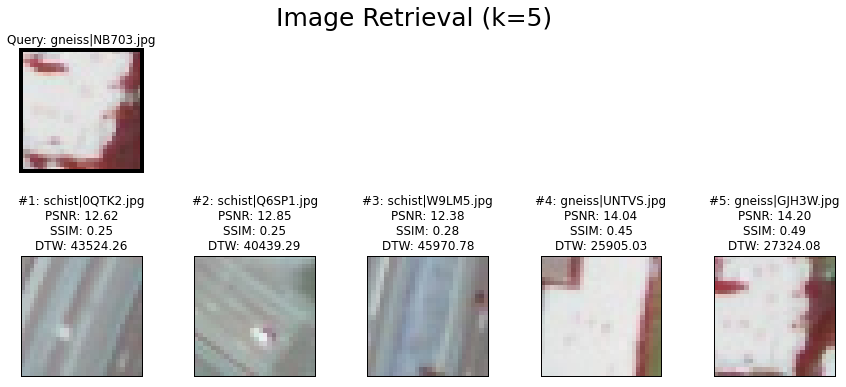

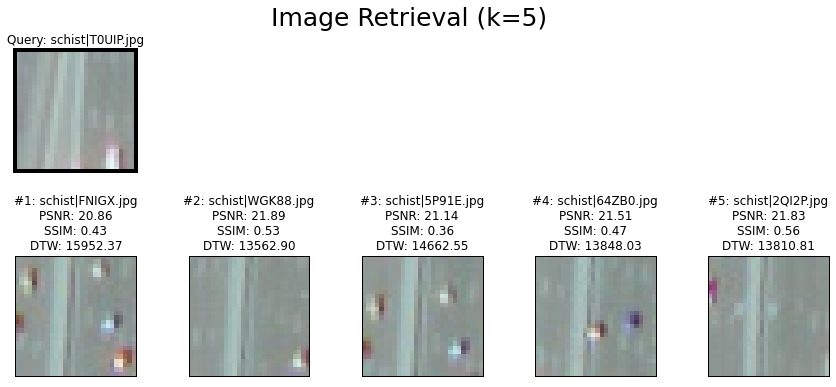

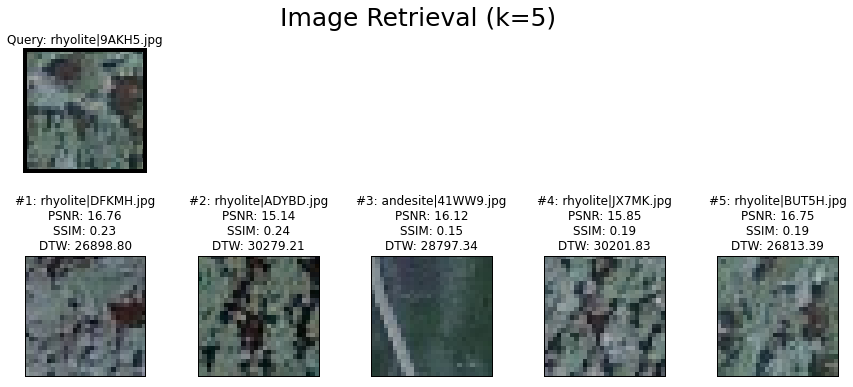

In [2]:
### KNN
from sklearn.neighbors import NearestNeighbors
from sewar.full_ref import mse, rmse, psnr, rmse_sw, uqi, ssim, ergas, scc, rase, sam, msssim, vifp, psnrb
from dtw import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


knn = NearestNeighbors(n_neighbors=5, metric="cosine")
knn.fit(train_encoded)


def plot_query_retrieval(img_query, imgs_retrievals, outFile, f_train, f_query):
    n_retrieval = len(imgs_retrievals)
    fig = plt.figure(figsize=(3 * n_retrieval, 6))
    fig.suptitle("Image Retrieval (k={})".format(n_retrieval), fontsize=25)

    # Plot query image
    ax = plt.subplot(2, n_retrieval, 0 + 1)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.7)
    plt.imshow(img_query)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(4)  # increase border thickness
        ax.spines[axis].set_color('black')  # set to black
    ax.set_title("{}".format('Query: '+str(f_query.split('/')[-2])+'|'+str(f_query.split('/')[-1].strip()), fontsize=14))  # set subplot title

    # Plot retrieval images
    for i, img in enumerate(imgs_retrievals):
        ax = plt.subplot(2, n_retrieval, n_retrieval + i + 1)
        ax.set_xlabel('aa')
        plt.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(1)  # set border thickness
            ax.spines[axis].set_color('black')  # set to black
        ir, iq = np.array(img), np.array(img_query)
        ax.set_title("#{}: {}\nPSNR: {:.2f}\nSSIM: {:.2f}\nDTW: {:.2f}".
                     format(i + 1, 
                            str(f_train[i].split('/')[-2])+'|'+str(f_train[i].split('/')[-1].strip()),
                            psnr(ir, iq),
                            ssim(ir, iq)[0],
                            dtw(ir.reshape(ir.shape[0]*ir.shape[2], ir.shape[1]), 
                                 iq.reshape(iq.shape[0]*iq.shape[2], iq.shape[1]), 
                                      distance_only=True, keep_internals=False).distance
                                      , fontsize=14))  # set subplot title

    if outFile is None:
        plt.show()
    else:
        plt.savefig(outFile, bbox_inches='tight')
    plt.close()

outDir = './images/'
modelName = '4PAE'
picks = [27,23,22,15,14]
for pick in picks:
    img_query = mpimg.imread(f_test[pick])
    # imgplot = plt.imshow(img_query)
    # plt.show()
    a, [indices] = knn.kneighbors([test_encoded[pick].numpy()])
    imgs_retrievals = [mpimg.imread(f_train[i]) for i in indices]
    outFile = os.path.join(outDir, "{}_retrieval_{}.png".format(modelName, i))
    plot_query_retrieval(img_query, imgs_retrievals, outFile=None, 
                         f_train=f_train[indices], f_query=f_test[pick])



## TSNE and UMAP Visualization

In [3]:
from sklearn.manifold import TSNE
from umap import UMAP

class Reduce_Dim():
    def __init__(self, method=None, components=3, n_neighbors=5):
        self.method = method
        self.components = components
        self.n_neighbors = n_neighbors
        # will initialized later
        self.tsne = None
        self.umap = None
    def __call__(self, weights, transform=False):
        """Reduce dimensions of embeddings"""
        if self.method == 'tsne':
            self.tsne = TSNE(self.components, metric='cosine')
            return self.tsne.fit_transform(weights)
        elif self.method == 'umap':
            if transform:
                return self.umap.transform(weights)
            else:
                # Might want to try different parameters for UMAP
                self.umap = UMAP(n_components=self.components, metric='cosine',
                            init='random', n_neighbors=self.n_neighbors)
                return self.umap.fit_transform(weights)
    def __getitem__(self, reducer_name):
        if reducer_name=='tsne':
            return self.tsne
        if reducer_name=='umap':
            return self.umap
    pass




### A. TSNE

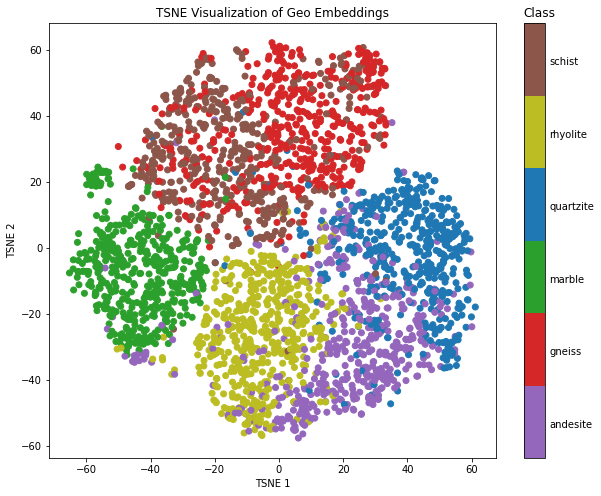

In [5]:
import pandas as pd
import numpy as np
import matplotlib as mpl

# create and train UMAP
tsne_reduce = Reduce_Dim(method='tsne', components=2)
all_tsne = tsne_reduce(torch.cat((train_encoded, test_encoded), 0))
# No tsne transformation for test, we can separate test
test_tsne = all_tsne[-len(test_encoded):]
# extracting labels
labels_tsne = torch.max(valid_labels, 1)[1].numpy().astype('int8')
geo_dict = {
    'andesite': 0,
    'gneiss': 1,
    'marble': 2,
    'quartzite': 3,
    'rhyolite': 4,
    'schist': 5
}
classes = ['andesite', 'gneiss', 'marble', 'quartzite', 'rhyolite', 'schist']
ints, gen = pd.factorize(classes)

# Viz of TSNE
plt.figure(figsize=(10, 8))
# Plot embedding
cmap = mpl.colors.ListedColormap(['tab:purple','tab:red', 'tab:green', 'tab:blue', 'tab:olive', 'tab:brown'])
plt.scatter(test_tsne[:,0], test_tsne[:,1],
            c=labels_tsne, cmap=cmap)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(gen):
    cbar.ax.text(6, (10 * j + 1) / ((6) * 2)+.3, lab, ha='left', va='center')
cbar.ax.set_title('Class', loc='left')

# To show centroids with name of each class
if False:
    for cls in list(geo_dict.keys()):
        x, y = test_tsne[np.where(labels_tsne==geo_dict[cls]), 0], \
               test_tsne[np.where(labels_tsne==geo_dict[cls]), 1];
        # Italize book title using latex
        s = ''.join([' $\it{' + word + '}$' for word in cls.split()])
        _ = plt.scatter(x, y, s=250, color='r',
                        marker='*', edgecolor='k')
        _ = plt.text(x - 10, y + 2, s, fontsize=10);

plt.xlabel('TSNE 1');
plt.ylabel('TSNE 2');
plt.title('TSNE Visualization of Geo Embeddings')
plt.show()

### B. UMAP

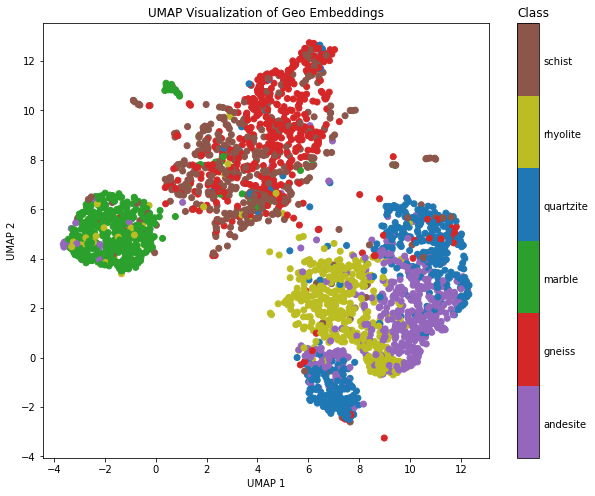

In [8]:
# create and train UMAP
umap_reduce = Reduce_Dim(method='umap', components=2, n_neighbors=5)
train_umap = umap_reduce(train_encoded)
# transform test with trained UMAP
test_umap = umap_reduce(test_encoded, transform=True)
# extracting labels
# [images_umap].append(torch.max(train_labels, 1)[1])
labels_umap = torch.max(valid_labels, 1)[1].numpy().astype('int8')

geo_dict = {
    'andesite': 0,
    'gneiss': 1,
    'marble': 2,
    'quartzite': 3,
    'rhyolite': 4,
    'schist': 5
}

classes = ['andesite', 'gneiss', 'marble', 'quartzite', 'rhyolite', 'schist']
ints, gen = pd.factorize(classes)

# Viz of UMAP
plt.figure(figsize=(10, 8))
# Plot embedding
cmap = mpl.colors.ListedColormap(['tab:purple','tab:red', 'tab:green', 'tab:blue', 'tab:olive', 'tab:brown'])
plt.scatter(test_umap[:,0], test_umap[:,1],
            c=labels_umap, cmap=cmap)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(gen):
    cbar.ax.text(6, (10 * j + 1) / ((6) * 2)+.3, lab, ha='left', va='center')
cbar.ax.set_title('Class', loc='left')

plt.xlabel('UMAP 1');
plt.ylabel('UMAP 2');
plt.title('UMAP Visualization of Geo Embeddings')
plt.show()